# Lab 4: Classification - Logistic Regression, LDA, & QDA
Classification is about predicting a categorical outcome (also called the class) for an observation based on known features. The training data allows a machine learning model to learn patterns and relationships in the data when the category or class of each data point is known. The model will determine a criteria for making class predictions. The goal of the testing data is to judge how well our model was able to accurately predict the class of new, unseen data. 

In this lab we will learn the importance of train-test split (i.e. the validation set approach), we will compare different models for classification, and we will learn how to evaluate our classification models.  

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot

## 0. Load and wrangle the data

We will be using the [Wisconsin Breast Cancer](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) dataset and try to predict whether a tumor is benign or malignant. In addition to whether the patient was diagnosed with a benign (B) or malignant (M) tumor, the dataset contains a set of features that describe characteristics of the cell nuclei present in the image.

In [2]:
# Load the data
data = pd.read_csv("data.csv")
print(data.shape)
data.head()

(569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


To simplify the example, we'll only take the first 10 features randomly. Of course, you would usually select the 10 most powerful features rather than randomly selecting them.

In [3]:
# Select the target and the first 10 features. Keep all the rows but select columns from 1 to 11 (12 is excluded)
data = data.iloc[:,1:12]

display(data.head())
print(data.shape)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


(569, 11)


All (supervised) `scikit-learn` models take the target and features as distinct inputs. Hence, we separate the data into X and y.

In [4]:
# Sort our target and features into different dataframes
X = data.drop(['diagnosis'], axis = 1)
y = data['diagnosis']

# Target categories frequency
y.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

We convert our label to binary values. It is good practice to rename the column name as well to avoid any confusion, but pandas series do not have a name so we can omit this step.

- Benign → 0
- Malignant → 1

In [5]:
## Convert to categorical before encoding. 
## By default, the codes are assigned in alphabetical order, with the first category getting
## code 0, the second getting code 1. You can define your custom order by

#from pandas.api.types import CategoricalDtype

## Define custom order (e.g., M first)
#cat_type = CategoricalDtype(categories=['M', 'B'], ordered=True)

## Convert column
#data['diagnosis'] = data['diagnosis'].astype(cat_type)

y = data['diagnosis'].astype('category').cat.codes

# Also perform sanity checks!
print(y.value_counts())

# Check the encoding
print(dict(enumerate(data['diagnosis'].astype('category').cat.categories)))

0    357
1    212
dtype: int64
{0: 'B', 1: 'M'}


We now have successfully loaded and wrangled our data into our input dataframes (X, y) and can move on with the train-test split.

## 1. Split the Data: Validation Set Approach.

Can't forget this! This is the only way to get a reliable estimate of your model's performance.

In [6]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

# Sanity check... Double check that the index of the train and test sets match
display(X_train.head(), X_test.head(), y_train.head(), y_test.head())

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
149,13.74,17.91,88.12,585.0,0.07944,0.06376,0.02881,0.01329,0.1473,0.05580
124,13.37,16.39,86.10,553.5,0.07115,0.07325,0.08092,0.02800,0.1422,0.05823
421,14.69,13.98,98.22,656.1,0.10310,0.18360,0.14500,0.06300,0.2086,0.07406
195,12.91,16.33,82.53,516.4,0.07941,0.05366,0.03873,0.02377,0.1829,0.05667
545,13.62,23.23,87.19,573.2,0.09246,0.06747,0.02974,0.02443,0.1664,0.05801


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
204,12.47,18.60,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,0.06373
70,18.94,21.31,123.60,1130.0,0.09009,0.1029,0.10800,0.07951,0.1582,0.05461
131,15.46,19.48,101.70,748.9,0.10920,0.1223,0.14660,0.08087,0.1931,0.05796
431,12.40,17.68,81.47,467.8,0.10540,0.1316,0.07741,0.02799,0.1811,0.07102
540,11.54,14.44,74.65,402.9,0.09984,0.1120,0.06737,0.02594,0.1818,0.06782


149    0
124    0
421    0
195    0
545    0
dtype: int8

204    0
70     1
131    1
431    0
540    0
dtype: int8

### Side Bar: Confirm that our train and test sets are balanced
It is good practice to make sure that our train and test sets are balanced. This means making sure that there are no significant differences between them. For this, we will merge the datasets back together while adding a dummy variable indicating whether a row comes from the training or the test set. We can then use this dummy variable as the independent variable in a regression and evaluate the p-values of all features.

Note that we only need to do this on the features. For the targets, you simply want to make sure that the labels are relatively well distributed among the train and test set.

In [7]:
# Make a copy of the training and test data
X_train_dummy = X_train.copy()
X_test_dummy = X_test.copy()

## Insert the dummy variable in each set. 
## df.insert(column #, 'column name', value)
X_train_dummy.insert(0, 'test', 0)
X_test_dummy.insert(0, 'test', 1)

## Merge the train and test set
## Recall in a previous lab where we created dummy variables and were adding new columns, 
## axis = 1 since it was a horizontal concatenation. 
X_full = pd.concat([X_test_dummy, X_train_dummy], axis = 0)

display(X_full)
print(X_full['test'].value_counts())

,test,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
204,1,12.470,18.60,81.09,481.9,0.09965,0.10580,0.08005,0.03821,0.1925,0.06373
70,1,18.940,21.31,123.60,1130.0,0.09009,0.10290,0.10800,0.07951,0.1582,0.05461
131,1,15.460,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796
431,1,12.400,17.68,81.47,467.8,0.10540,0.13160,0.07741,0.02799,0.1811,0.07102
540,1,11.540,14.44,74.65,402.9,0.09984,0.11200,0.06737,0.02594,0.1818,0.06782
...,...,...,...,...,...,...,...,...,...,...,...
71,0,8.888,14.64,58.79,244.0,0.09783,0.15310,0.08606,0.02872,0.1902,0.08980
106,0,11.640,18.33,75.17,412.5,0.11420,0.10170,0.07070,0.03485,0.1801,0.06520
270,0,14.290,16.82,90.30,632.6,0.06429,0.02675,0.00725,0.00625,0.1508,0.05376
435,0,13.980,19.62,91.12,599.5,0.10600,0.11330,0.11260,0.06463,0.1669,0.06544


0    398
1    171
Name: test, dtype: int64


What we essentially did was add the train set to the bottom of the test set. Notice how the index is all shuffled, which is a result of the randomization of the train-test-split.

Now, we can simply run a regression with `test` as the independent variable being predicted by all the features.

In [8]:
result = smf.ols(
    'test ~ radius_mean + texture_mean + perimeter_mean + area_mean + smoothness_mean + compactness_mean + concavity_mean + symmetry_mean + fractal_dimension_mean',
    data = X_full
).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   test   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.5553
Date:                Fri, 31 Jan 2025   Prob (F-statistic):              0.834
Time:                        07:38:59   Log-Likelihood:                -361.12
No. Observations:                 569   AIC:                             742.2
Df Residuals:                     559   BIC:                             785.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

All of the p-values are larger than 0.1, hence, we can be less worried that the train and test set are significantly different. This is good news. Otherwise, a model trained on the training set would not be able to predict the test set well. 

However, we MUST acknowledge the possibility that the training and test set can very unbalanced on characteristics that we haven't included or are simply unobservable. The ability to become aware of what you don't know is one of the most powerful skills you can develop for statistical analysis. 


With the labels, it is often sufficient to compute the percentage of positive labels (i.e., percentage of malignant) and see if this ratio is approximately equal. In this case, it is true.

In [9]:
## Check the label distribution in the training and test sets
## Notice we can take the mean to check the distribution since benign = 0, malignant = 1
print(f'Percentage of positive labels in the test set: {round(y_test.mean()*100, 2)}')
print(f'Percentage of positive labels in the training set: {round(y_train.mean()*100, 2)}')

Percentage of positive labels in the test set: 36.84
Percentage of positive labels in the training set: 37.44


Of course, the larger the sample and the more balanced it is, the less likely we are to run into issues here. Hence, if you have small sample and/or variables with some "outliers" (in the sense that there are only few observations with values in a rare range), you should take this step very seriously.

### Back to the lab
Anyways, now that we have made sure that our train-test split is of good quality in the sense that none of our features are significantly correlated to the 'test' dummy (i.e., being in a test or train set), we can continue with build our model.

## 2. Let's start with OLS; we will learn why it's not the best model to use for classification problems.


Since the models we discuss were developed to outperform the OLS model when predicting categorical (i.e., classification), it is useful to see how it does to set a benchmark.

### Sidebar: Scikit Learn vs. Statsmodels
__Statsmodels is for inference; Scikit Learn is for predictions!!__

In the last few weeks we have primarily used the Statsmodels package to run regressions. This strength of Statsmodels is that you can run a regression and see the model's coefficients and their statistical significance very easily. 

With Scikit Learn, you aren't able to view the model's coefficients as easily. This is because the primary function of Scikit Learn is to make predictions on data. The strength of Scikit Learn is that you can very easily see the predicted outcomes for a given set of X features. 

Now that we are transitioning into true machine learning, we will use the Scikit Learn packages to handle classification and other prediction problems. 

### Back to the lab!

In [10]:
# Define and train the OLS model
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

# Predict the labels on the test set
y_pred_ols = model.predict(X_test)

Of course, one problem of using OLS for classification is that its predictions will not necessarily lie between 0 and 1. This is a problem because we know that we want to outcome of our model (i.e. its predictions) to be a classification: 0 for benign, 1 for malignant. 

In [11]:
# 10 first predictions
y_pred_ols[:10]

array([0.2545099 , 0.78391203, 0.7383423 , 0.10432796, 0.03194086,
       1.56782097, 1.34188845, 0.64738314, 0.58479897, 0.05768623])

Another problem of using OLS for classification is that its continuous predictions will have no significant meaning. Our outcome classification is a dummy variable representing 0 for benign, 1 for malignant. There is no numerical significance of these values, so the predictions have no true meaning.

<AxesSubplot: ylabel='Count'>

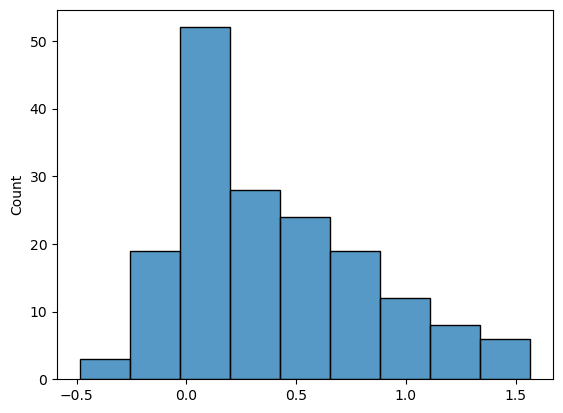

In [12]:
# Histogram of the predictions
sns.histplot(y_pred_ols)

To turn those continuous predictions into binary ones, we can use a threshold. Here, we will use the somewhat arbitrary threshold of 0.7 above which we will classify an observation as malignant (M) and below it as benign (B).

In [13]:
# Continuous to binary predictions
y_pred_ols_bin = np.where(y_pred_ols > 0.7, 1, 0)

y_pred_ols_bin[:10]

array([0, 1, 1, 0, 0, 1, 1, 0, 0, 0])

Accuracy is a common and intuitive metric for evaluating classification models. It measures the percentage of labels correctly predicted by the model:

$$ Accuracy\ Score = \frac{Nb.\ Correct\ Predictions}{Nb.\ Total\ Predictions} $$

Whether a model's accuracy score is good depends on the baseline. The baseline is the accuracy you would get by always guessing the most common label in the test set. To evaluate a model, we compare its accuracy to this baseline. If the model can't do better than always guessing the most common label, it isn’t useful. 

In [18]:
## Initialize accuracy tracking dictionary (i.e. create an empty dictionary 
## where different accuracy values will be stored).
accuracies = {} 

# Computing the baseline accuracy
# The baseline accuracy is the probablility of assigning classes randomly to the observations.
# It is calculated by taking the probability of selecting the class with the most number of observations in the data.
## y_test.value_counts() just counts occurences of each class
## .max() will retrieve the class with the highest count 
accuracies['baseline'] = round(y_test.value_counts().max()/len(y_test), 2)

# Compute the accuracy
## Recall we had set the threshold for probability (OLS prediction) to outcome (benign or not) via 
## y_pred_ols_bin = np.where(y_pred_ols > 0.7, 1, 0)
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
accuracies['OLS'] = accuracy_score(y_test, y_pred_ols_bin)

# Print the accuracies
## Right now, 
## accuracies = {
##     'baseline' = accuracies['baseline'],
##     'OLS' = accuracies['OLS']
##     }
## .items() then returns pairs of key (i.e. model name) - value (i.e. accuracy score)
for model, accuracy in accuracies.items():
    print(f'{model} accuracy: {round(accuracy, 4)*100}%')


baseline accuracy: 63.0%
OLS accuracy: 88.3%


We are also interested to see if there are certain categories that are harder to predict for the model. A confusion matrix gives us a pretty good idea on whether that is the case for a particular model.

![ConfusionMatrix.png](ConfusionMatrix.png)

In [19]:
cm_ols = confusion_matrix(y_test, y_pred_ols_bin, normalize = 'true')
print(cm_ols)

[[1.         0.        ]
 [0.31746032 0.68253968]]


This display of the confusion matrix is obviously not very digestible. Let's make a heatmap out of it!

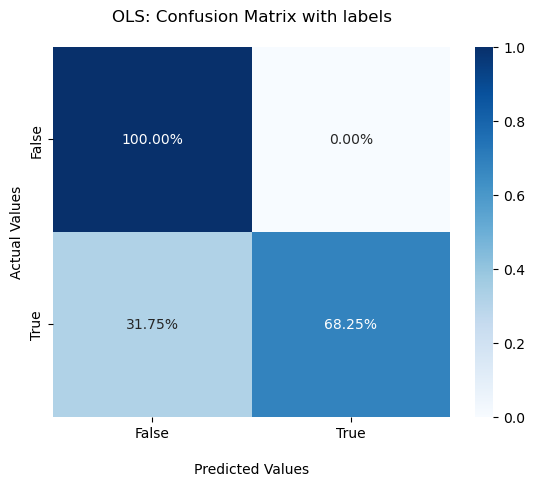

In [20]:
ax = sns.heatmap(cm_ols, annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('OLS: Confusion Matrix with labels\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

We see that the model predicts all (actual) benign (False) correctly. However, it performs less good on (actual) malignant (True) observations that it often (wrongly) predicts as benign.

As the plot below shows, this is not surprising  as the threshold of 0.7 is above any predicted (continuous) probability by OLS for (actual) benign (False) observations.

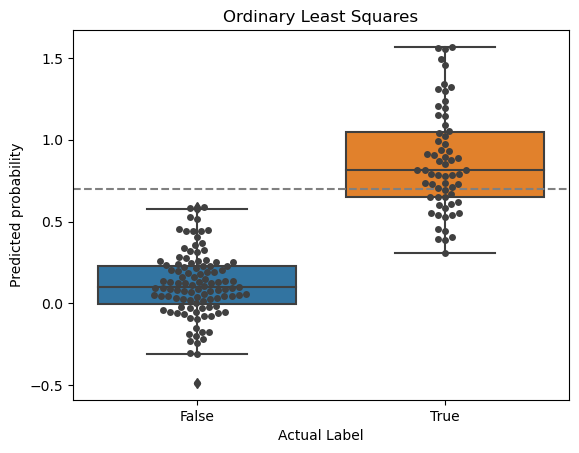

In [21]:
# Visualize with a box/swarmplot
ax = sns.boxplot(x=y_test, y=y_pred_ols)
ax = sns.swarmplot(x=y_test, y=y_pred_ols, color = ".25")
ax.axhline(0.7, ls = '--', color = 'grey')
ax.xaxis.set_ticklabels(['False','True'])
ax.set_xlabel('Actual Label')
ax.set_ylabel('Predicted probability')
ax.set_title('Ordinary Least Squares')
plt.show()

We know that OLS is not optimized for classification problems, so how do the other models perform? Let's see!

## 3. Logistic Regression

A logistic regression has the advantage of predicting probabilities within 0 and 1.

$$ p(x) = \frac{1}{1 + e^{-(\beta_{0} + \beta_{1}x)}} $$


where:

- $p(x)$ is the predicted probability that $x$ belongs to the positive class.
- $\beta_{0}$ is the intercept term.
- $\beta_{1}$ is the coefficient associated with the predictor variable $x$.
- $e$ is the base of the natural logarithm.

The interpretation of the model is as follows:

$\beta_{0}$ and $\beta_{1}$ are the parameters to be estimated from the training data.
The logistic function transforms the linear combination of $\beta_{0}$ and $\beta_{1}x$ into a probability value between 0 and 1.
The logistic function $\frac{1}{1 + e^{-z}}$ maps any real-valued number $z$ to the range [0, 1].
The logistic regression model predicts the probability of the positive class based on the input feature $x$.

The parameters $\beta_{0}$ and $\beta_{1}$ are learned during the training process. Once the model is trained, it can be used to predict the probability of belonging to the positive class for new instances.

It's worth noting that when $x = \mu$ (the mean of the distribution), the predicted probability $p(\mu)$ is $\frac{1}{2}$. This is a notable property of logistic regression, indicating that when the input is at the mean value, the model predicts an equal probability of belonging to either class.


In [29]:
# Fit the model
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(max_iter=500)
logisticRegr.fit(X_train, y_train)

# Predict the test set
y_pred_log = logisticRegr.predict_proba(X_test)
y_pred_log[:5]

array([[0.90202569, 0.09797431],
       [0.02218961, 0.97781039],
       [0.23062869, 0.76937131],
       [0.88104427, 0.11895573],
       [0.98460553, 0.01539447]])

Notice that the logistic regression predicts the probabilities of an observation belonging to each class. Those probabilities hence sum up to 1 for each observation.

As expected, when plotting the likelihood of a tumor being malignant, we see that we now have probabilities that are bounded between 0 and 1. Additionally, we can see that the low and high probabilities are much more common than the mid-range probabilites. This is good as it means that we don't have to make any "close" decisions.

<AxesSubplot: ylabel='Count'>

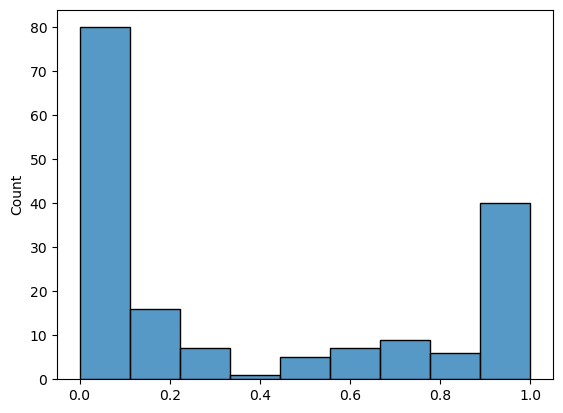

In [30]:
# Binary classification, so we only need one probability
y_pred_log = y_pred_log[: ,1]

# show the probabilities that observations will be classified as 1 (Malignant)
sns.histplot(y_pred_log)

In [31]:
# Compute the accuracy
accuracies['logit'] = accuracy_score(y_test, logisticRegr.predict(X_test))

# Print the accuracies
for model, accuracy in accuracies.items():
    print(f'{model} accuracy: {round(accuracy, 4)*100}%')

baseline accuracy: 63.0%
OLS accuracy: 88.3%
logit accuracy: 93.57%


Looking at the heatmap again, we notice that the logistic regression is also predicting the (actually) benign (False) mostly correctly and is doing slightly better on the (actually) malignant (True) than OLS. Hence, the accuracy improvement is coming from there.

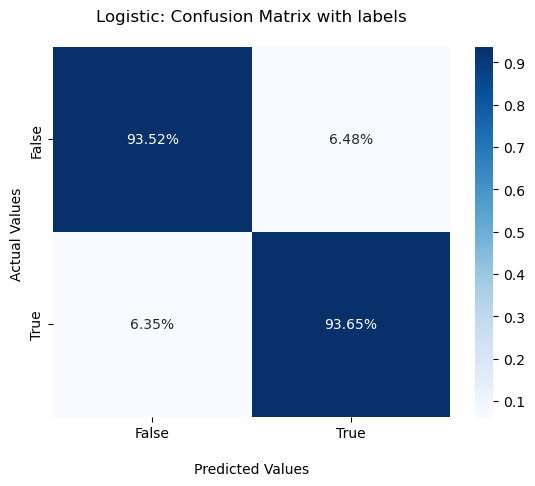

In [32]:
# Confusion Matrix
ax = sns.heatmap(
    confusion_matrix(
        y_test,
        logisticRegr.predict(X_test),
        normalize = 'true'
    ),
    annot=True, 
    fmt='.2%',
    cmap='Blues'
)

# Title and Labels
ax.set_title('Logistic: Confusion Matrix with labels\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

# Display the visualization of the Confusion Matrix.
plt.show()

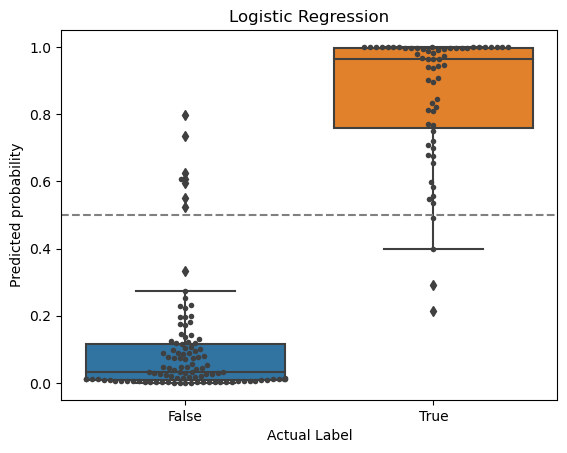

In [47]:
# Visualize with a box/swarmplot
ax = sns.boxplot(x=y_test, y=y_pred_log)
ax = sns.swarmplot(x=y_test, y=y_pred_log, color = ".25", size = 4)
ax.axhline(0.5, ls = '--', color = 'grey')
ax.xaxis.set_ticklabels(['False','True'])
ax.set_xlabel('Actual Label')
ax.set_ylabel('Predicted probability')
ax.set_title('Logistic Regression')
plt.show()

## 4. Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis is also a way to model categorical outcome variables, but takes a different approach than the logistic regression.

Like logistic regression, LDA makes a prediction based on a linear decision boundary. However, while logistic regressions model the probability of success directly $(P(y=k|X))$, LDA models it indirectly $(P(X|Y=k))$ via Bayes' theorem. This simply means that Logistic Regression directly models the probability of the outcome, while LDA models the probability of the features given the outcome. LDA aims to understand how likely it is to observe a specific combination of features when the class is known. Basically, LDA works backwards (i.e. given y, what are my predicted x features) and builds a prediction model this way. 

LDA requires more assumptions than logistic regressions, but LDA works better than logit if they are met:
- Classes are well separated
- N is small
- Distribution of X is approximately normal

In [34]:
# Fit the LDA model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [35]:
# view the predicted test values
y_pred = lda_model.predict(X_test)
y_pred

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int8)

LDA also has a high accuracy, but it doesn't necessarily perform better than logit.

In [36]:
# Compute the accuracy
accuracies['LDA'] = accuracy_score(y_test, y_pred)
# Print the accuracies
for model, accuracy in accuracies.items():
    print(f'{model} accuracy: {round(accuracy, 4)*100}%')

baseline accuracy: 63.0%
OLS accuracy: 88.3%
logit accuracy: 93.57%
LDA accuracy: 93.57%


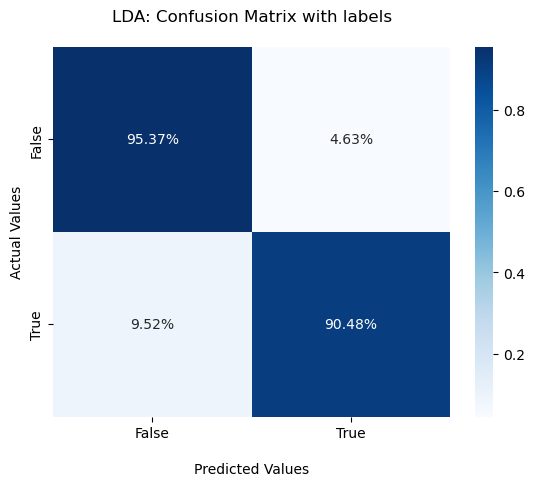

In [37]:
# Confusion Matrix
ax = sns.heatmap(
    confusion_matrix(
        y_test,
        y_pred,
        normalize = 'true'
    ),
    annot=True,
    fmt='.2%',
    cmap='Blues'
)

ax.set_title('LDA: Confusion Matrix with labels\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()


## 5. Quadratic Discriminant Analysis (QDA)

LDA assumes that every class has the same variance/covariance, which might lead to poor performance if that assumption is untrue.

Quadratic Discriminant Analysis works the same as LDA, but it estimates separate variance/covariance for each class. It also makes predictions based on a non-linear decision boundary.

In [38]:
# Fit the QDA model
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [39]:
# view the predicted test values
y_pred_q = qda_model.predict(X_test)
y_pred_q

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int8)

In [40]:
# Compute the accuracy
accuracies['QDA'] = accuracy_score(y_test, y_pred_q)

# Print the accuracies
for model, accuracy in accuracies.items():
    print(f'{model} accuracy: {round(accuracy, 4)*100}%')

baseline accuracy: 63.0%
OLS accuracy: 88.3%
logit accuracy: 93.57%
LDA accuracy: 93.57%
QDA accuracy: 94.15%


Don't let the fact that our logit, LDA, and QDA model perform almost equally well fool you; there are potentially large differences. It all depends on the data and how well it is suited for each type of classification model.

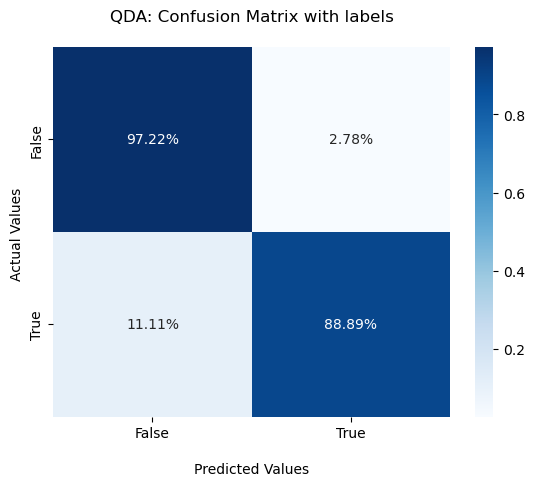

In [41]:
import matplotlib.pyplot as plt

ax = sns.heatmap(
    confusion_matrix(
        y_test,
        y_pred_q,
        normalize = 'true'
    ),
    annot=True, 
    fmt='.2%',
    cmap='Blues'
)

ax.set_title('QDA: Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

A final note on the confusion matrix. Ideally, we would want to correctly predict all observations correctly, however, that is rarely the case.

Sometimes, one wants to avoid false negatives more than false positives or vice-versa. Then, one can manipulate the probability threshold required to classify an observation into a category over another, but that will often require an accuracy tradeoff.

For instance, we could imagine that we want to avoid predicting a (actually) malignant tumor as benign. Then, you could set the required probability to classify an observation as benign to 80% for example (and maybe even create a new "unsure" category).

## 6. Evaluating the models.

Keep in mind that for classification problems, we use accuracy and error rate to judge the performance of our models. Whereas for regression problems, where the outcome variable is continuous, we use MSE to evaluate the performance of our models. 

Let's remind ourselves of the different accuracy scores for each model.

In [42]:
# Print the accuracies
for model, accuracy in accuracies.items():
    print(f'{model} accuracy: {round(accuracy, 4)*100}%')

baseline accuracy: 63.0%
OLS accuracy: 88.3%
logit accuracy: 93.57%
LDA accuracy: 93.57%
QDA accuracy: 94.15%


We could have also used the error rate to evaluate our models because: 
$$ Accuracy = 1 - Error Rate$$
$$ Error Rate = 1 - Accuracy$$

Let's see the error rates of each of our models:

In [43]:
# Print the error rates
for model, accuracy in accuracies.items():
    error_rate = 1 - accuracy
    print(f'{model} error rate: {round(error_rate, 4)*100}%')

baseline error rate: 37.0%
OLS error rate: 11.700000000000001%
logit error rate: 6.43%
LDA error rate: 6.43%
QDA error rate: 5.8500000000000005%


We generally determine the best model by selecting the model with the _highest accuracy score_, or inversely, the _lowest error rate_. However, depending on the context of the problem, there may be other factors to consider when determining the "best" model. 